In [1]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using LinearAlgebra
import ProgressMeter
using WAV
using Plots

In [2]:
include("helpers/aida_segmentation.jl")
include("helpers/aida_snr.jl")
include("helpers/aida_ar.jl")
include("models_inferences.jl")

batch_coupled_learning (generic function with 1 method)

In [6]:
# priors
bmθ = [1.25231, -0.424707]
bvθ = [0.0074575971735365044 -0.005614127136793097; -0.005614127136793097 0.006163152988713943]
bγ  = [41.0, 0.0005125367871437023]

2-element Vector{Float64}:
 41.0
  0.0005125367871437023

In [15]:
speech_bar, fs = wavread("sound/mixed/bar_speech.wav")
sb_seg = get_frames(speech_bar, fs)

352×80 Matrix{Float64}:
 -0.001648     -0.00521867    0.000701926  …  -0.0147099    -0.0122684
  0.004944      0.00994903    0.00769066      -0.00250252   -0.00601215
  0.00061037    0.000793481   0.00424207       0.0100406     0.00918607
 -0.00738548   -0.0036317    -0.00292978       0.0215155     0.0177923
  0.00210578    0.00155644    0.00491348      -0.0097354    -0.0151067
  0.001648     -0.00112918   -0.007416     …  -0.0124516    -0.00564592
 -0.000640889  -0.00134281    0.00302133      -0.00680563   -0.00625629
  0.00390637    0.00582904    0.00686666      -0.00457778   -0.00399792
 -0.0101627    -0.00442518   -0.000885037     -0.00701926   -0.0108341
  0.00753807    0.000488296  -0.00207526       0.0157476     0.0120853
 -0.0126041    -0.00534074   -0.00140385   …   0.0137028     0.0119633
 -0.00518815   -0.00424207   -0.00271615      -0.000824      0.00479141
  0.00640889    0.00225837   -0.00381481       0.0143132     0.0163274
  ⋮                                        ⋱   

In [16]:
# obtaining prior for BAR
totseg = size(sb_seg, 1)
ar_order = 2
rmθ = zeros(totseg, ar_order)
rvθ = zeros(totseg, ar_order, ar_order)
for segnum in 1:totseg
    rmθ[segnum, :], rvθ[segnum, :, :] = bmθ, bvθ
end
priors_eta = rmθ, rvθ
priors_tau = [(bγ[1], bγ[2]) for _ in 1:totseg]

352-element Vector{Tuple{Float64, Float64}}:
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 ⋮
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)
 (41.0, 0.0005125367871437023)

In [17]:
function agent_weigths(sources_num)
    w = zeros(sources_num); w[1] = 1.0
    return w
end

agent_weigths (generic function with 1 method)

In [18]:
function HA_algorithm(segments, priors_η, priors_τ, ar_1_order, ar_2_order, vmp_its)
    totseg = size(segments, 1)
    l      = size(segments, 2)
    rmx = zeros(totseg, l)
    rvx = zeros(totseg, l)
    rmθ = zeros(totseg, ar_1_order)
    rvθ = zeros(totseg, ar_1_order, ar_1_order)
    rγ = fill(tuple(.0, .0), totseg)
    
    rmz = zeros(totseg, l)
    rvz = zeros(totseg, l)
    rmη = zeros(totseg, ar_2_order)
    rvη = zeros(totseg, ar_2_order, ar_2_order)
    rτ = fill(tuple(.0, .0), totseg)
    
    fe  = zeros(totseg, vmp_its)
    
    rmo= zeros(totseg, l)
    
    ProgressMeter.@showprogress for segnum in 1:totseg
        # get weights
        weights                           = agent_weigths(2)
        prior_η                           = (priors_η[1][segnum, :], priors_η[2][segnum, :, :])
        prior_τ                           = priors_τ[segnum]
        γ, θ, zs, τ, η, xs, fe[segnum, :] = coupled_inference(segments[segnum, :], prior_η, prior_τ, ar_1_order, ar_2_order, vmp_its)
        mz, vz                            = mean.(zs), cov.(zs)
        mθ, vθ                            = mean(θ), cov(θ)
        rmz[segnum, :], rvz[segnum, :]    = first.(mz), first.(vz)
        rmθ[segnum, :], rvθ[segnum, :, :] = mθ, vθ
        rγ[segnum]                        = shape(γ), rate(γ)
        
        mx, vx                            = mean.(xs), cov.(xs)
        mη, vη                            = mean(η), cov(η)
        rmx[segnum, :], rvx[segnum, :]    = first.(mx), first.(vx)
        rmη[segnum, :], rvη[segnum, :, :] = mη, vη
        rτ[segnum]                        = shape(τ), rate(τ)
        
        # HA part
        speech = rmz[segnum, :] .* weights[1]
        noise  = rmx[segnum, :] .* weights[2]
        rmo[segnum, :] = speech .+ noise
    end
    rmz, rvz, rmθ, rvθ, rγ, rmx, rvx, rmη, rvη, rτ, fe, rmo
end

HA_algorithm (generic function with 1 method)

In [19]:
rmz, rvz, rmθ, rvθ, rγ, rmx, rvx, rmη, rvη, rτ, fe, rmo = HA_algorithm(sb_seg, priors_eta, priors_tau, 10, 2, 10);

Progress: 100%|█████████████████████████████████████████| Time: 0:04:01


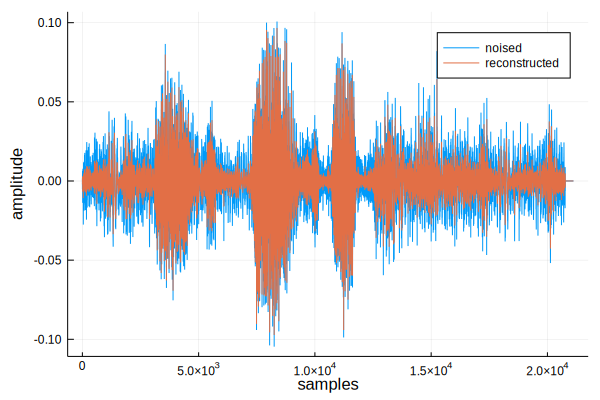

In [23]:
ha_out = get_signal(rmo, fs)
plot(get_signal(sb_seg, fs), label=:noised, ylabel="amplitude", xlabel="samples")
plot!(ha_out, label="reconstructed")

In [24]:
wavwrite(ha_out, fs, "sound/processed/ha_output.wav")

In [27]:
; python3 spectrogram.py

/Users/apodusenko/Documents/Julia/AIDA/spectrogram.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, y = wavfile.read("sound/speech/sp02.wav")
/Users/apodusenko/Documents/Julia/AIDA/spectrogram.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, x = wavfile.read("sound/mixed/bar_speech.wav")
